## Find the Baseline Peak for the Model
Katherine Elder

The purpose of this notebook is to correctly find and plot the delay spectrum peak which corresponds to the baseline. 

Since we are only looking at the baseline component, our model equation looks like:

V_ij = P_ij $*$ e^(-i $*$ pi $*$ tau_aij $*$ nu) $*$ (V_ii + V_jj)

The first task is to import necessary packages, define constants, and read in the data. We also create an array to hold the baseline (in seconds) for every possible antenna pair.

In [102]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

#Create uv elements
uv = UVData()

#Variable for the speed of light
c = 2.99792 * 1e8

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,84,98,136])

# Read in the xy data file
uv.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

#Define frequency variable. This makes life easier and code cleaner when using this array
#Nu is in Hz, or 1/seconds
nu = uvxy.freq_array

#Create a dictionary which associates the antenna number with the indexing number in uv.antenna_numbers
#This is used to find antennas in the matrix arrays
ant_dict = {x: i for i,x in enumerate(uv.antenna_numbers)}

#Create the baseline dependent tau matrix
taus_a = np.zeros((len(uv.antenna_numbers),len(uv.antenna_numbers)))
i = 0
j = 0
for ind,coord in enumerate(uv.uvw_array):
    #This if statement iterates the indicies for the created tau array
    if j==52:
        #When j hits 52, it has reached the end of the list of antennas
        #This means that we need to move to the next line and so i is iterated
        #But we cannot simply reset j to zero because the uvw array does not repeat baselines
        #We set j equal to i, as the new row will start will the autocorr baseline
        i = i + 1
        j = i
    #Calculate the absolute distance in meters separating the antenna pair
    taus_a[i,j] = np.sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) 
    #Convert tau from meters into seconds
    taus_a[i,j] = taus_a[i,j] / c
    #Iterate the j index
    j = j + 1

We define variables for the antenna pair we will be looking at. It is defined here for ease of access if we decide to change the antenna numbers.

In [207]:
#Define antenna numbers for the pair we wish to look at
antenna1 = 54
antenna2 = 55

### Part 1: Correct Location

Now that we have selected the antenna pair, we find the corresponding (baseline) delay in our tau matrix. 

With the tau defined, we can calculate the exponential term of our model equation. This is the term that controls where on the axis the peak will be plotted. There are two correction factors in this term that are not listed in the original equation at the beginning of the notebook. 

The first term is a correction to tau by adding an extra 10 ns. This was found empirically by looking at many different antenna pairs and noticing that the peak was shifted slightly in the data and not in the model. I have not determined yet what could be causing the extra 10 ns, which corresponds to 3 meters.

The second term is an amplitude correction by dividing. The model has, in general, a far greater amplitude than the actual data. Instead of just trying to correct for this in each graph, I am attempting to minimize it within the equations as we go. This will help correct the total amplitude when it comes time to add all the pieces of the model together. The value was chosen mostly at random and may change as time goes on. 

In [208]:
#Define the tau variable for the specified antenna pair
#Since the array created is upper triangular, we must index using an if statement
if antenna1<antenna2:
    tau_aij = taus_a[ant_dict[antenna1],ant_dict[antenna2]]
else:
    tau_aij = taus_a[ant_dict[antenna2],ant_dict[antenna1]]

print 'Tau_aij (m) :',tau_aij*c
print 'Tau_aij (ns):',tau_aij*1e9

#Define the exponential term
e_aij = np.e**(nu * np.pi * (-1j) * 2 * (tau_aij + 1e-8)) / 20

Tau_aij (m) : 14.607978563217197
Tau_aij (ns): 48.72704596259138


Now that we have the exponential term, let's take the delay transform and plot with the real data. In this process, we find the peak of the model and it's location. This is used to help find the amplitude and delay in the real data and create a correction factor so that the model plots at the same amplitude. 

In [209]:
#Delay transforms

#Delay transform of e_a
vis_avg_delay_exp = np.mean(np.fft.fftshift(np.fft.fft(e_aij,axis=1)),axis=0)

model_max = np.max(np.abs(vis_avg_delay_exp))
print 'Model peak value:',model_max
blin_peak = np.argwhere(np.abs(vis_avg_delay_exp)==model_max)
blin_peak = int(blin_peak)
print 'Model peak location:', blin_peak


#Delay transform of the real data
#First, we read in the data from the data array
spectra = []
for index,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[index]
    #Locate the antenna pair we want
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        #Place the data into the array created outside of the loop
        spectra = uvxy.data_array[index,0,:,0]

#Take the fourier transform of the data
vis_avg_delay_real = np.fft.fftshift(np.fft.fft(spectra))

#Find the frequency width of a channel in GHz
freq_width_real = np.diff(uvxy.freq_array[0,:])[0]

#Convert frequencies to delays and convert to ns
delays_real = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_real)*1e9)

#Find the amplitude of the baseline peak
real_bl_max = np.max(np.abs(vis_avg_delay_real[(blin_peak-1):(blin_peak+1)]))
#Find the maxmimum amplitude of the graph. If the baseline is short, this is the same as above
real_abs_max = np.max(np.abs(vis_avg_delay_real))
print 'Baseline peak value:', real_bl_max
print 'Maximum peak value :', real_abs_max
print 'Baseline peak location:', np.argwhere(np.abs(vis_avg_delay_real)==real_bl_max)

Model peak value: 49.846151592270196
Model peak location: 506
Baseline peak value: 112.03342
Maximum peak value : 112.03342
Baseline peak location: [[506]]


The correction factor: 0.4449221762500534


<IPython.core.display.Javascript object>


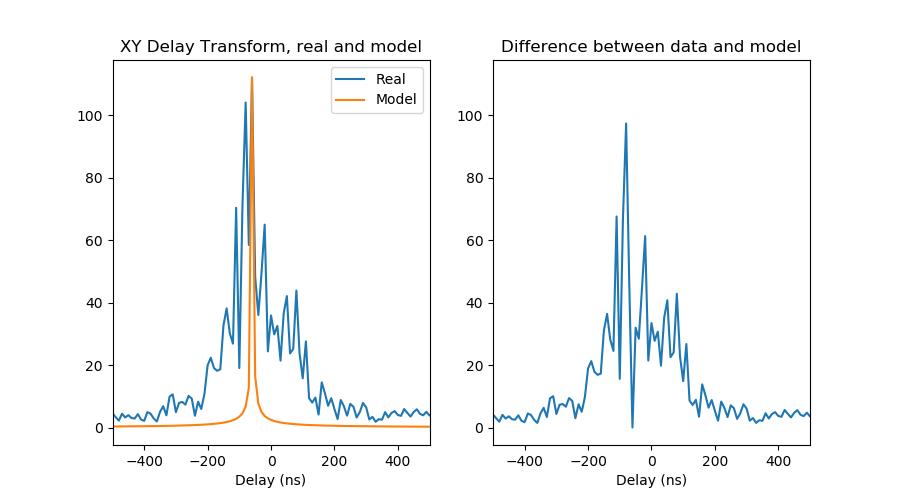

Text(0.5,1,'Difference between data and model')

In [210]:
#Plot

#Calculate the correction factor so that the model is plotted with the same amplitude as the data
corr_factor = model_max / real_bl_max
print 'The correction factor:', corr_factor

#Open the figures so that if one is zoomed in, the other zooms as well
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_real),np.abs(vis_avg_delay_real), label='Real')
plt.plot((delays_real),np.abs(vis_avg_delay_exp)/corr_factor, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_real, np.abs(np.abs(vis_avg_delay_real)-np.abs(vis_avg_delay_exp)/corr_factor))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')

### Part 2: Other variables

Now that we have confirmed that the model is printing the peak in the correct location, we can go through and start creating the other variables from our equation. These are the autocorrelation data for both antenna and the amplitude factor in front. 

The amplitude factor is found by creating a matrix of the amplitudes for every antenna pair, then taking the mean across the antenna to find the average amplitude for each antenna. 

We also multiply the exponential found eariler by the two autocorrelated data to create a term we will call V_aij. This term has the second amplitude correction factor dividing. 

In [211]:
#Create an array to hold the autocorrelation data
V_k = np.zeros((len(ant_nums),uvxy.Nfreqs),dtype='complex')

# Step through each antenna and find autocorr data
for i,ant1 in enumerate(uv.ant_2_array):
    ant2 = uv.ant_1_array[i]
    if (ant1==ant2):
        x = uv.data_array[i,0,:,0]
        V_k[ant_dict[ant1]] = x
        
#Define autocorr variables
V_ii = V_k[ant_dict[antenna1]]
V_jj = V_k[ant_dict[antenna2]]

#Define baseline dependent term
V_aij = ((e_aij * V_ii) + (e_aij * V_jj)) / 20

Now we create the amplitude array. We are only looking at the peaks around the baseline for each antenna pair. Once the peak is found, we put it into our amplitude matrix. 

In [212]:
#The first dimension is there so that we can multiply the matricies later
#Dimentions 2 and 3 hold the matrix of antenna pairs
bl_amp = np.zeros([1,len(ant_nums),len(ant_nums)])

#Step through the antenna array to find every baseline
for index,ant1 in enumerate(uvxy.ant_2_array):
    #Get the second antenna number using the index number
    ant2 = uvxy.ant_1_array[index]

    #Flag out dead antennas
    if np.any(ant1==flagged_antennas) or np.any(ant2==flagged_antennas):
        continue
    
    #Find the baseline delay
    baseline = 0
    if ant1<ant2:
        tau_b = taus_a[ant_dict[ant1],ant_dict[ant2]]
    else:
        tau_b = taus_a[ant_dict[ant2],ant_dict[ant1]]
    #Calculate the exponential as done earlier with the new tau delay
    expo = np.e**(nu * np.pi * (-1j) * 2 * tau_b)
    #Take the delay transform
    vis_expo = np.mean(np.fft.fftshift(np.fft.fft(expo,axis=1)),axis=0)
    #Find the maximum value
    expo_max = np.max(np.abs(vis_expo))
    #Find the location of the maximum, which is the baseline
    expo_peak = int(np.argwhere(np.abs(vis_expo)==expo_max))
    # Create an array to hold the real data
    spectrum = uv.data_array[index,0,:,0]
    # Fourier transform along the time axis
    vis = np.fft.fftshift(np.fft.fft(spectrum))
    freq_width = np.diff(uv.freq_array[0,:])[0]
    #Convert frequencies to delays and convert to ns
    con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs, freq_width))*1e9
    #Find the peak at the baseline
    bl_peak = np.max(np.abs(vis)[expo_peak-2:expo_peak+3])
    # Append the amplitude array with the peak
    bl_amp[0,ant_dict[ant1],ant_dict[ant2]] = bl_peak
    bl_amp[0,ant_dict[ant2],ant_dict[ant1]] = bl_peak
    
print 'Baseline amplitude array:', bl_amp.shape

Baseline amplitude array: (1, 52, 52)


Next, we define our amplitude array by taking the average of the amplitude matrix we just created. Once we have the amplitude array, we can finish creating our model. This is divided by our final extra amplitude correction factor. 

Finally, we take the delay transform and find the maximum value to calculate the graphing correction factor, and plot the model with the real data. 

In [213]:
#Take the average across antennas to calculate the amplitude factor
P_ij = np.mean(bl_amp,axis=1)

#Finish building our model
bl_model = np.einsum('im,ij->mj',P_ij,V_aij) / 20

#Take the delay transform
vis_bl_model = np.mean(bl_model,axis=0)
vis_bl_model = np.fft.fftshift(np.fft.fft(vis_bl_model))

#Find the maximum value
model_max2 = np.max(np.abs(vis_bl_model))

Correction factor: 0.2643374205342931


<IPython.core.display.Javascript object>


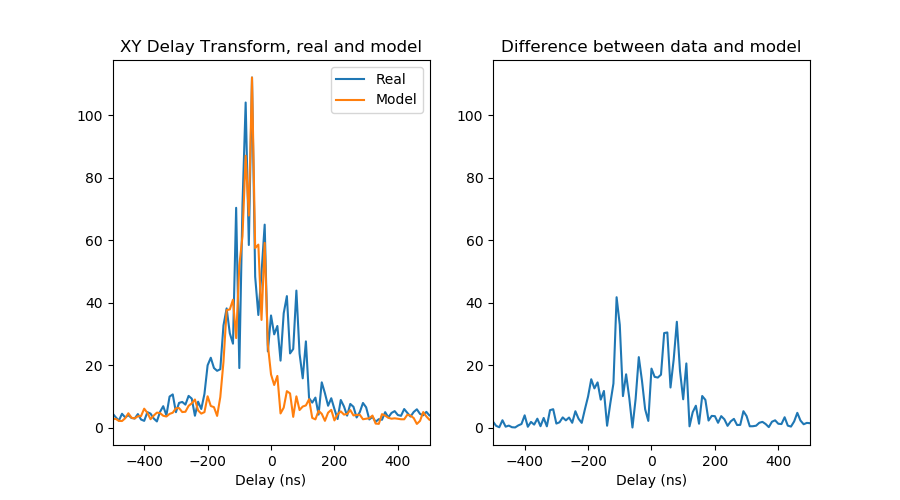

Text(0.5,1,'Difference between data and model')

In [214]:
#Plot
#Find the correction factor
corr_factor1 = model_max2 / real_bl_max
print 'Correction factor:', corr_factor1

#Open the figures so that if one plot is zoomed, the other zooms as well
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

plt.subplot(ax1)
plt.plot((delays_real),np.abs(vis_avg_delay_real), label='Real')
plt.plot((delays_real),np.abs(vis_bl_model)/corr_factor1, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

plt.subplot(ax2)
plt.plot(delays_real, np.abs(np.abs(vis_avg_delay_real)-(np.abs(vis_bl_model)/corr_factor1)))
plt.xlabel('Delay (ns)')
plt.title('Difference between data and model')